In [71]:
!pip install pyspark

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml


In [73]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
from google.colab import drive
import pandas as pd
drive.mount('content')
df=pd.read_csv('/train.csv')
df

Mounted at content


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [75]:
from pyspark.sql import SparkSession
#Initialize Spark session
spark = SparkSession.builder.appName("TitanicKNN").getOrCreate()
#Load data
train_data = spark.read.csv("/train.csv", header=True, inferSchema=True)

train_data.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [76]:
#Load the Titanic dataset
titanic = fetch_openml(name='titanic', version=1, as_frame=True)
df = titanic.frame
df

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,None,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None
1305,3.0,0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None
1306,3.0,0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None
1307,3.0,0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None


In [77]:
#Drop rows with missing target values
df = df.dropna(subset=["survived", "pclass", "age", "sibsp", "parch", "fare"])

#Select relevant features and label
feature_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X = df[feature_cols]
y = df['survived']

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [78]:
#standard scaler
def custom_standard_scaler(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    scaled_X = (X - mean) / std
    return scaled_X

#Scale the data using standard scaler
X_train_scaled = custom_standard_scaler(X_train)
X_test_scaled = custom_standard_scaler(X_test)


In [79]:
#create a visualization for accuracy
k_values = range(1, 25)
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

#best K value
best_k = k_values[np.argmax(accuracy_scores)]
print(f"Best K value: {best_k}")

Best K value: 20


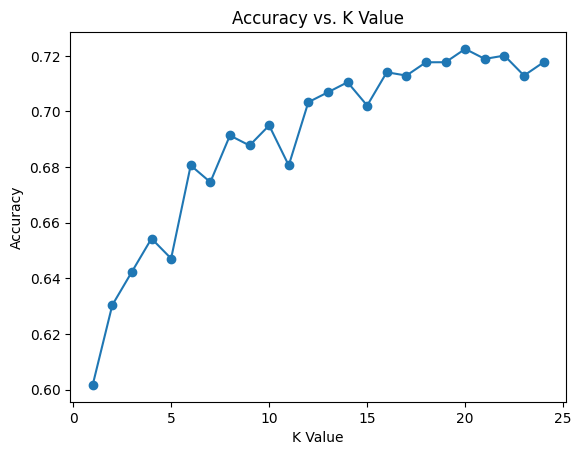

In [80]:
#Create a visualization of the accuracy
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K Value')
plt.show()

In [81]:
#columns to fill
columns_to_fill = ['age', 'fare']

#Replace null values with mean
X_train_scaled[columns_to_fill] = X_train_scaled[columns_to_fill].fillna(X_train_scaled[columns_to_fill].mean())

X_train_scaled

,pclass,age,sibsp,parch,fare
322,-1.439803,0.448781,-0.564704,-0.497249,1.852363
64,-1.439803,-0.176144,0.530638,-0.497249,0.307657
1220,0.939002,0.171036,-0.564704,-0.497249,-0.535505
728,0.939002,0.934834,-0.564704,-0.497249,-0.535505
1244,0.939002,-0.939942,0.530638,0.657474,-0.526770
...,...,...,...,...,...
387,-0.250400,1.282015,-0.564704,1.812196,0.001648
968,0.939002,0.448781,0.530638,-0.497249,-0.395134
910,0.939002,-0.870506,-0.564704,-0.497249,-0.552818
875,0.939002,0.032164,-0.564704,-0.497249,-0.550867


In [84]:
#Train model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)
#confusion matrix on test set
y_pred = knn_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for training set:")
print(cm)

Confusion Matrix for training set:
[[103  15]
 [ 40  51]]


In [85]:
#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)

#Calculate accuracy
accuracy = (con_matrix[0, 0] + con_matrix[1, 1]) / np.sum(con_matrix)

#Accuracy
print("Confusion Matrix for test set:")
print(con_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix for test set:
[[103  15]
 [ 40  51]]

Accuracy: 0.7368421052631579
